### Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams.update({'font.size':10,'figure.figsize':(16,6)})

from datetime import date
from nsepy import get_history

### Get the data from NSE India website

In [3]:
def get_data(ticker):
    df=get_history(symbol=ticker,
                   start=date(2007,7,4),
                   end=date.today())
    print(f"{ticker} Information \n")
    print(df.info())
    print("--- --- --- "*10)
    print(f"{ticker} 5 Point Summary \n")
    print(df.describe())
    return df
#    df_cpy=df.copy()

### Checking anomalies in data

In [16]:
def check_anomalies(df_cpy):
   
    # Adjusting the effect of stock split
    #df_cpy=df_cpy.reset_index()
    df_cpy['Date']=pd.to_datetime(df_cpy['Date'])
  
    df1=df_cpy.copy()
    
    split=['2018-05-31','2009-06-16']
    #split=['2018-05-31']
    for x in split:
        df_cpy.iloc[df_cpy['Date']< x ,3:10] = df_cpy.iloc[:,3:10]*(1/2)
        df_cpy.loc[df_cpy['Date']< x ,'Volume'] = df_cpy.loc[:,'Volume']*2
    
    # plotting the graph to differentiate between the stock split in data set and after adjusting stock split in dataset
    
    plt.plot(df_cpy['Date'],df_cpy['Close'],color='Blue',label='Without Stock Splits')
    plt.plot(df1['Date'],df1['Close'],color='red',label='With Stock Splits')
    plt.annotate(text='Stock split 1',xy=('2009-06-15',787),xytext=('2009-04-10',950),
                arrowprops=dict(facecolor='black',arrowstyle='simple'))
    plt.annotate(text='Stock split 2',xy=('2018-05-30',3550),xytext=('2018-10-20',3530),
                arrowprops=dict(facecolor='black',arrowstyle='simple'))
    plt.legend(loc='upper left')
    plt.show()
    
    # adjusting the anomalies in 'Prev Close' feature in records after adjusting the split
    df_cpy.loc[df_cpy['Close'].shift(1)!=df_cpy['Prev Close'],'Prev Close']=df_cpy['Close'].shift(1)
    

### Preparing Indicators

###### Simple Moving Average

In [5]:
def SMA(data,period,column):
    return data[column].rolling(window=period).mean()

###### Exponential Moving Average

In [6]:
def EMA(data,period,column):
    return data[column].ewm(span=period,adjust=False).mean()

###### Relative strength index

In [7]:
def RSI(data,period,column):
    df1=pd.DataFrame()
    delta=data[column].diff(1)
    delta=delta[1:]
    up=delta.copy()
    down=delta.copy()
    up[up<0]=0
    down[down>0]=0
    df1['up']=up
    df1['down']=down
    AVG_gain=SMA(df1,period,column='up')
    AVG_loss=abs(SMA(df1,period,column='down'))
    RS=AVG_gain/AVG_loss
    RSI=100-(100/(1+RS))
    return RSI

###### Bollinger Band

In [8]:
def Bollingerband(data,period,column):
    multiplier = 2
    data['Middle Band'] = data[column].rolling(period).mean()
    data['Upper Band']= data['Middle Band'] + multiplier*(data[column].rolling(period).std())
    data['Lower Band']= data['Middle Band'] - multiplier*(data[column].rolling(period).std())
    
    multiplier = 1
    data['Middle Upper']= data['Middle Band'] + multiplier*(data[column].rolling(period).std())
    data['Middle Lower']= data['Middle Band'] - multiplier*(data[column].rolling(period).std())

### Function to add indicators to dataset

In [9]:
def prepare_indicators(df_cpy):
    
    # Simple moving average
    df_cpy['SMA_21']=SMA(df_cpy,period=21,column='Close')
    df_cpy['SMA_5']=SMA(df_cpy,period=5,column='Close')

    # Exponential moving average
    df_cpy['EMA_21']=EMA(df_cpy,period=21,column='Close')
    df_cpy['EMA_5']=EMA(df_cpy,period=5,column='Close')
    
    # Bollinger Band
    Bollingerband(df_cpy,period=21,column='Close')   
    
    # Relative strength index
    df_cpy['RSI_14']=RSI(df_cpy,period=14,column='Close')
    df_cpy['RSI_9']=RSI(df_cpy,period=9,column='Close')
    
    # Creating EMA on RSI
    df_cpy['EMA_RSI_9']=EMA(df_cpy,period=9,column='RSI_9')
    df_cpy['EMA_RSI_3']=EMA(df_cpy,period=3,column='RSI_9')
    
    # % change in price
    df_cpy['price_chg_1']=((df_cpy['Prev Close']-df_cpy['Close'])/df_cpy['Prev Close'])*100
    df_cpy['price_chg_5']=(df_cpy['Close'].diff(5)/df_cpy['Close'].shift(5))*100
    
    # % change in volume
    df_cpy['vol_chg_1']=(df_cpy['Volume'].diff(1)/df_cpy['Volume'].shift(1))*100
    df_cpy['vol_chg_3']=(df_cpy['Volume'].diff(3)/df_cpy['Volume'].shift(3))*100
    df_cpy['vol_chg_7']=(df_cpy['Volume'].diff(7)/df_cpy['Volume'].shift(7))*100
    
    # PLot the entire chart
    
    plt.plot(df_cpy['Date'][3000:],df_cpy['Close'][3000:],color='Blue',label='TCS Price chart')
    plt.plot(df_cpy['Date'][3000:],df_cpy['Middle Band'][3000:],label='Middle Band')
    plt.plot(df_cpy['Date'][3000:],df_cpy['Upper Band'][3000:],label='Upper Band')
    plt.plot(df_cpy['Date'][3000:],df_cpy['Lower Band'][3000:],label='Lower Band')
    plt.plot(df_cpy['Date'][3000:],df_cpy['SMA_21'][3000:],label='SMA_21')
    plt.plot(df_cpy['Date'][3000:],df_cpy['EMA_21'][3000:],label='EMA_21')
    plt.plot(df_cpy['Date'][3000:],df_cpy['SMA_5'][3000:],label='SMA_5')
    plt.plot(df_cpy['Date'][3000:],df_cpy['EMA_5'][3000:],label='EMA_5')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    plt.plot(df_cpy['Date'][3000:],df_cpy['RSI_14'][3000:],label='RSI_14')
    plt.plot(df_cpy['Date'][3000:],df_cpy['RSI_9'][3000:],label='RSI_9')
    plt.plot(df_cpy['Date'][3000:],df_cpy['EMA_RSI_9'][3000:],label='EMA_RSI_9')
    plt.plot(df_cpy['Date'][3000:],df_cpy['EMA_RSI_3'][3000:],label='EMA_RSI_3')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
      

In [10]:
def prepare_indicators1(df_cpy):
    
    # Simple moving average
    df_cpy['SMA_21']=SMA(df_cpy,period=21,column='Close')
    df_cpy['SMA_5']=SMA(df_cpy,period=5,column='Close')

    # Exponential moving average
    df_cpy['EMA_21']=EMA(df_cpy,period=21,column='Close')
    df_cpy['EMA_5']=EMA(df_cpy,period=5,column='Close')
    
    # Bollinger Band
    Bollingerband(df_cpy,period=21,column='Close')   
    
    # Relative strength index
    df_cpy['RSI_14']=RSI(df_cpy,period=14,column='Close')
    df_cpy['RSI_9']=RSI(df_cpy,period=9,column='Close')
    
    # Creating EMA on RSI
    df_cpy['EMA_RSI_9']=EMA(df_cpy,period=9,column='RSI_9')
    df_cpy['EMA_RSI_3']=EMA(df_cpy,period=3,column='RSI_9')
    
    # % change in price
    df_cpy['price_chg_1']=((df_cpy['Prev Close']-df_cpy['Close'])/df_cpy['Prev Close'])*100
    df_cpy['price_chg_5']=(df_cpy['Close'].diff(5)/df_cpy['Close'].shift(5))*100
    
    # % change in volume
    df_cpy['vol_chg_1']=(df_cpy['Volume'].diff(1)/df_cpy['Volume'].shift(1))*100
    df_cpy['vol_chg_3']=(df_cpy['Volume'].diff(3)/df_cpy['Volume'].shift(3))*100
    df_cpy['vol_chg_7']=(df_cpy['Volume'].diff(7)/df_cpy['Volume'].shift(7))*100
       
    # PLot the entire chart
    
    plt.plot(df_cpy['Date'][3350:],df_cpy['Close'][3350:],color='Blue',label='TCS Price chart')
    plt.plot(df_cpy['Date'][3350:],df_cpy['Middle Band'][3350:],label='Middle Band')
    plt.plot(df_cpy['Date'][3350:],df_cpy['Upper Band'][3350:],label='Upper Band')
    plt.plot(df_cpy['Date'][3350:],df_cpy['Lower Band'][3350:],label='Lower Band')
    plt.plot(df_cpy['Date'][3350:],df_cpy['SMA_21'][3350:],label='SMA_21')
    plt.plot(df_cpy['Date'][3350:],df_cpy['EMA_21'][3350:],label='EMA_21')
    plt.plot(df_cpy['Date'][3350:],df_cpy['SMA_5'][3350:],label='SMA_5')
    plt.plot(df_cpy['Date'][3350:],df_cpy['EMA_5'][3350:],label='EMA_5')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    plt.plot(df_cpy['Date'][3350:],df_cpy['RSI_14'][3350:],label='RSI_14')
    plt.plot(df_cpy['Date'][3350:],df_cpy['RSI_9'][3350:],label='RSI_9')
    plt.plot(df_cpy['Date'][3350:],df_cpy['EMA_RSI_9'][3350:],label='EMA_RSI_9')
    plt.plot(df_cpy['Date'][3350:],df_cpy['EMA_RSI_3'][3350:],label='EMA_RSI_3')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### Feature Engineering

In [11]:
def feature_ext(df_new,column='Close'):
    
    
    # features related to Bollinger band
    df_new['B/w_upper_middle'] = np.where((df_new[column]>= df_new['Middle Band'])&(df_new[column]< df_new['Upper Band']), 1, 0)
    df_new['B/w_middle_lower'] = np.where((df_new[column]<= df_new['Middle Band'])&(df_new[column]> df_new['Lower Band']), 1, 0)
    df_new['Above_Upper'] = np.where(df_new[column]> df_new['Upper Band'], 1, 0)
    df_new['Below_Lower'] = np.where(df_new[column]< df_new['Lower Band'], 1, 0)
    df_new['Near_Middle'] = np.where((df_new[column]< df_new['Middle Upper'])&(df_new[column]> df_new['Middle Lower']), 1, 0)
    df_new['Near_Upper']  = np.where((df_new[column]>= df_new['Middle Upper']), 1, 0)
    df_new['Near_Lower']  = np.where((df_new[column]<= df_new['Middle Lower']), 1, 0)
    
    
    # feature related to % change
    df_new['last_change'] = np.where(df_new['price_chg_1']>0, 1, 0)
    df_new['last_5day_change'] = np.where(df_new['price_chg_5']>0, 1, 0)
    df_new['last_change_1%'] = np.where(df_new['price_chg_1']>=1, 1, 0)
    df_new['last_5day_change_3%'] = np.where(df_new['price_chg_5']>=3, 1, 0)
    
    
    # features related to SMA & EMA
    df_new['MA_5'] = np.where(df_new['EMA_5']> df_new['SMA_5'], 1, 0)
    df_new['MA_21'] = np.where(df_new['EMA_21']> df_new['SMA_21'], 1, 0)
    df_new['Above_SMA_21'] = np.where(df_new[column]> df_new['SMA_21'], 1, 0)
    df_new['Above_EMA_21'] = np.where(df_new[column]> df_new['EMA_21'], 1, 0)
    df_new['Above_SMA_5'] = np.where(df_new[column]> df_new['SMA_5'], 1, 0)
    df_new['Above_EMA_5'] = np.where(df_new[column]> df_new['EMA_5'], 1, 0)
    
    
    # features related to change in volume
    df_new['last_vol_chng'] = np.where(df_new['vol_chg_1'] > 0, 1, 0)
    df_new['last3_vol_chng'] = np.where(df_new['vol_chg_3'] > 0, 1, 0)
    df_new['last7_vol_chng'] = np.where(df_new['vol_chg_7'] > 0, 1, 0)
    
    df_new['Net_vol_chng'] = np.where(df_new['vol_chg_3']>df_new['vol_chg_1'], 
                                      np.where(df_new['vol_chg_7']>df_new['vol_chg_1'],
                                               np.where(df_new['vol_chg_7']>df_new['vol_chg_3'],1,0),0),0 )

    
    # features related to RSI
    
    # rsi_14
    df_new['Strength_rsi_14'] = np.where(df_new['RSI_14']>60,'Bullish', 
                                         np.where(((df_new['RSI_14'] <=60)&(df_new['RSI_14'] >=40)),'Hold','bearish'))
    
    # rsi_9
    
    flag_bullish = np.where(df_new['EMA_RSI_3']>df_new['EMA_RSI_9'], 
                            np.where(df_new['EMA_RSI_3']>df_new['EMA_RSI_9'].shift(1), 
                                     np.where(df_new['EMA_RSI_3'].diff()>0,True,False),False),False)  
    
    flag_bearish = np.where(df_new['EMA_RSI_3']>df_new['EMA_RSI_9'], 
                            np.where(df_new['EMA_RSI_3']>df_new['EMA_RSI_9'].shift(1), 
                                     np.where(df_new['EMA_RSI_3'].diff()<0,True,False),False),False)  
 
    df_new['Strength_rsi_9'] = np.where(df_new['RSI_9']>=50, 
                                        np.where(flag_bullish,'bullish','hold'),                                     
                                        np.where(flag_bearish,'bearish','hold'))

    
    # features realted to VWAP
    df_new['Above_VWAP'] = np.where(df_new[column] > df_new['VWAP'], 1, 0)

   

### Target features

In [12]:
def create_target(df_new):
    
    # price after 5 days
    df_new['target_5']=df_new['Close'].shift(-5)
    
    # price after 10 days
    df_new['target_10']=df_new['Close'].shift(-10)
    
    # % change in price after 5 days
    df_new['tgt5_%chng']=((df_new['target_5']-df_new['Close'])/df_new['Close'])*100
    
    # % change in price after 10 days
    df_new['tgt10_%chng']=((df_new['target_10']-df_new['Close'])/df_new['Close'])*100

### Evaluating different targets

In [13]:
def target_cal(df_new):
    
    # target after 5 days  > 3% or < -3%
    df_new['tgt_5d_3%']=np.where(df_new['tgt5_%chng']>3, 1,
                                 np.where(df_new['tgt5_%chng']<-3,-1,0))
    
    # target after 5 days > 5% or < -5%
    df_new['tgt_5d_5%']=np.where(df_new['tgt5_%chng']>5, 1,
                                 np.where(df_new['tgt5_%chng']<-5,-1,0)) 
    
    # target after 5 days > 7% or < -7%
    df_new['tgt_5d_7%']=np.where(df_new['tgt5_%chng']>7, 1,
                                 np.where(df_new['tgt5_%chng']<-7,-1,0)) 
    
    
    
    # target after 10 days > 7% or < -7%
    df_new['tgt_10d_7%']=np.where(df_new['tgt10_%chng']>7, 1,
                                 np.where(df_new['tgt10_%chng']<-7,-1,0)) 
    
    # target after 10 days > 10% or < -10%
    df_new['tgt_10d_10%']=np.where(df_new['tgt10_%chng']>10, 1,
                                 np.where(df_new['tgt10_%chng']<-10,-1,0)) 
    
    # target after 10 days > 12% or < -12%
    df_new['tgt_10d_12%']=np.where(df_new['tgt10_%chng']>12, 1,
                                 np.where(df_new['tgt10_%chng']<-12,-1,0))   
    

### Remove redundant columns and removing null values

In [14]:
def remove_redundancy(df_new):
    
    print("Shape of dataset before removing redundancy :",df_new.shape)
    col=['Symbol','Series','Turnover','Trades','Deliverable Volume','%Deliverble']
    df_new.drop(col,axis=1,inplace=True)
    df_new.dropna(inplace=True)
    df_new.set_index('Date',drop=True,inplace=True)
    print("Shape of dataset after removing redundancy :",df_new.shape)   
    

### Main Function

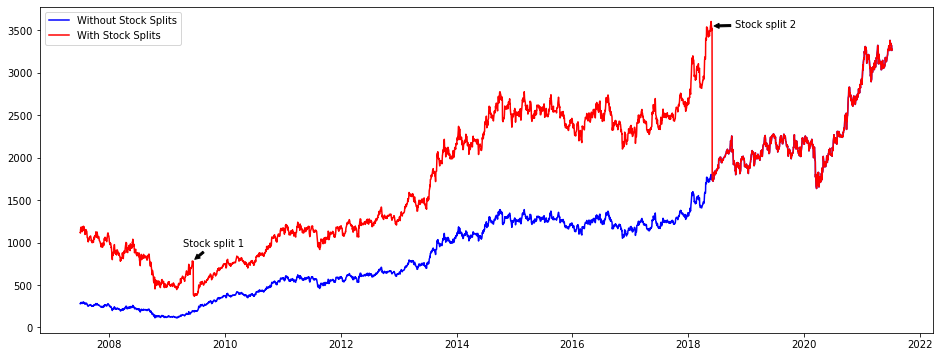

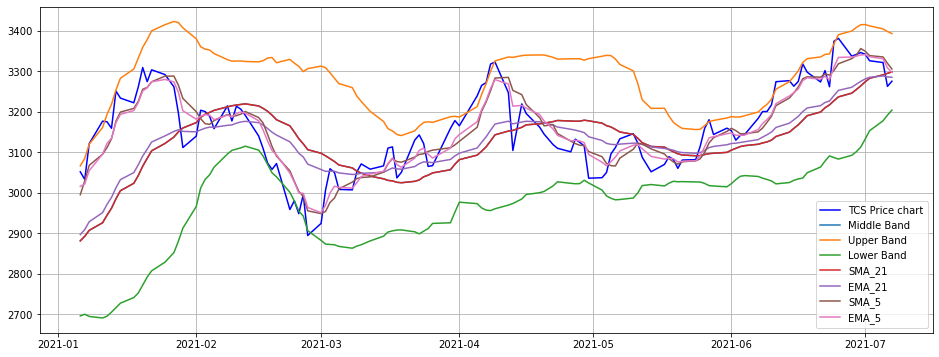

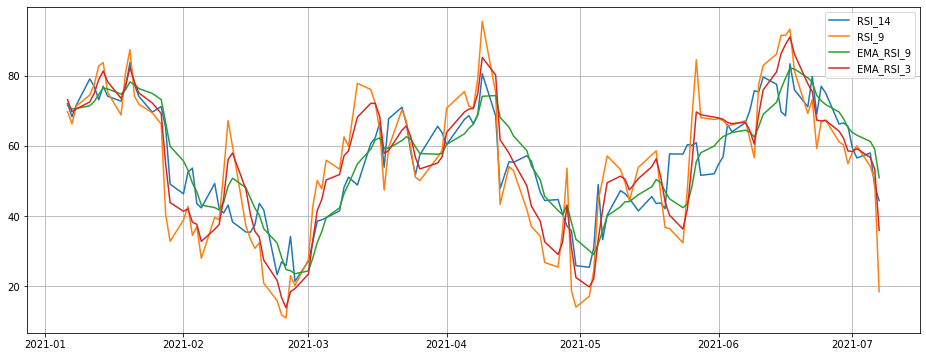

Shape of dataset before removing redundancy : (3474, 43)
Shape of dataset after removing redundancy : (3444, 36)


In [19]:
#df=get_data('TCS')
#df.to_csv('TCS_data_test')

df=pd.read_csv('TCS_data_test.csv')
# Creating a copy of ordiginal data
df_cpy=df.copy()

# Checking different anomalies in the data
check_anomalies(df_cpy)

# Preparing indicators for the data
prepare_indicators1(df_cpy)

# Making a copy of entire data with indicators value
df_new=df_cpy.copy()

# Create target feature
create_target(df_new)

# Evaluating different targets
target_cal(df_new)

# Remove redundant columns or column with no significance
remove_redundancy(df_new)

# Feature engineering
feature_ext(df_new)





In [23]:
df_new.head()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,SMA_21,SMA_5,...,Above_EMA_21,Above_SMA_5,Above_EMA_5,last_vol_chng,last3_vol_chng,last7_vol_chng,Net_vol_chng,Strength_rsi_14,Strength_rsi_9,Above_VWAP
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-01,289.0750,285.000,286.250,277.575,278.50,278.7875,279.4000,4403436,288.870833,287.5000,...,0,0,0,1,1,0,0,Hold,hold,0
2007-08-02,278.7875,280.000,281.125,272.500,275.75,273.7875,276.2275,1912008,288.602976,282.8025,...,0,0,0,0,1,0,0,Hold,hold,0
2007-08-03,273.7875,278.500,278.500,270.775,274.00,274.2250,274.1725,1993756,288.427381,279.9975,...,0,0,0,1,0,0,0,Hold,hold,1
2007-08-06,274.2250,272.500,279.500,268.500,276.25,274.8625,273.4425,2737548,287.722619,278.1475,...,0,0,0,1,0,0,0,bearish,hold,1
2007-08-07,274.8625,278.275,279.450,273.525,276.75,277.3250,276.3850,2985212,286.919643,275.7975,...,0,1,0,1,1,0,0,bearish,hold,1


In [107]:
df_new.shape

(3444, 60)

In [108]:
df_new.isnull().sum()

Prev Close             0
Open                   0
High                   0
Low                    0
Last                   0
Close                  0
VWAP                   0
Volume                 0
SMA_21                 0
SMA_5                  0
EMA_21                 0
EMA_5                  0
Middle Band            0
Upper Band             0
Lower Band             0
Middle Upper           0
Middle Lower           0
RSI_14                 0
RSI_9                  0
EMA_RSI_9              0
EMA_RSI_3              0
price_chg_1            0
price_chg_5            0
vol_chg_1              0
vol_chg_3              0
vol_chg_7              0
target_5               0
target_10              0
tgt5_%chng             0
tgt10_%chng            0
tgt_5d_3%              0
tgt_5d_5%              0
tgt_5d_7%              0
tgt_10d_7%             0
tgt_10d_10%            0
tgt_10d_12%            0
B/w_upper_middle       0
B/w_middle_lower       0
Above_Upper            0
Below_Lower            0


In [109]:
df_new[['Volume','vol_chg_1','vol_chg_3','vol_chg_7','last_vol_chng','last3_vol_chng','last7_vol_chng','Net_vol_chng']]

,Volume,vol_chg_1,vol_chg_3,vol_chg_7,last_vol_chng,last3_vol_chng,last7_vol_chng,Net_vol_chng
Date,,,,,,,,
2007-08-01,4403436,36.814705,37.468360,-6.636763,1,1,0,0
2007-08-02,1912008,-56.579180,4.148492,-38.858318,0,1,0,0
2007-08-03,1993756,4.275505,-38.054024,-25.332301,1,0,0,0
2007-08-06,2737548,37.306070,-37.831548,-54.395512,1,0,0,0
2007-08-07,2985212,9.046928,56.129681,-6.806367,1,1,0,0
...,...,...,...,...,...,...,...,...
2021-06-17,2273413,38.999738,23.062803,-11.679772,1,1,0,0
2021-06-18,3380431,48.694100,159.039836,97.579146,1,1,1,0
2021-06-21,1130569,-66.555478,-30.875386,-39.681240,0,0,0,0


In [82]:
df_new['Net_vol_chng'].value_counts()

0    2832
1     612
Name: Net_vol_chng, dtype: int64

In [84]:
df_new[['Close','target_5','target_10','tgt5_%chng','tgt10_%chng']].head(10)

,Close,target_5,target_10,tgt5_%chng,tgt10_%chng
Date,,,,,
2007-08-01,278.7875,288.1500,272.0000,3.358293,-2.434650
2007-08-02,273.7875,286.4250,264.0375,4.615806,-3.561156
2007-08-03,274.2250,286.1250,263.8875,4.339502,-3.769715
2007-08-06,274.8625,283.6250,253.8125,3.187958,-7.658375
2007-08-07,277.3250,282.5625,256.4750,1.888578,-7.518255
2007-08-08,288.1500,272.0000,251.9750,-5.604720,-12.554225
2007-08-09,286.4250,264.0375,254.6000,-7.816182,-11.111111
2007-08-10,286.1250,263.8875,256.6250,-7.771953,-10.310179
2007-08-13,283.6250,253.8125,257.1875,-10.511238,-9.321287


In [94]:
df_new[df_new['tgt5_%chng']>5]['Net_vol_chng'].value_counts()

0    315
1     67
Name: Net_vol_chng, dtype: int64

In [96]:
df_new[df_new['tgt5_%chng']<-5]['Strength_rsi_9'].value_counts()

hold       165
bullish     71
bearish      5
Name: Strength_rsi_9, dtype: int64

In [93]:
df_new['Net_vol_chng'].value_counts()

0    2832
1     612
Name: Net_vol_chng, dtype: int64

In [87]:
a= np.where(df_new['tgt5_%chng']>3, 1,
         (df_new['tgt5_%chng']<3,1,0),0)

TypeError: where() takes from 1 to 3 positional arguments but 4 were given

In [89]:
a=np.where(df_new['tgt5_%chng']>3, 1,
         np.where(df_new['tgt5_%chng']<-3,1,0))

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
a= np.where(df_new['tgt5_%chng']>5, 1,
         (df_new['tgt5_%chng']<5,1,0),0)

In [97]:
df_new['Strength_rsi_9'].value_counts()

hold       2290
bullish    1092
bearish      62
Name: Strength_rsi_9, dtype: int64

In [98]:
df_new['Strength_rsi_14'].value_counts()

Hold       1489
Bullish    1187
bearish     768
Name: Strength_rsi_14, dtype: int64

In [99]:
df_new['tgt10_%chng'].describe()

count    3444.000000
mean        0.877045
std         5.591212
min       -32.437663
25%        -2.394901
50%         0.764939
75%         4.070359
max        31.481481
Name: tgt10_%chng, dtype: float64

In [100]:
df_new['tgt5_%chng'].describe()

count    3444.000000
mean        0.447088
std         4.093192
min       -21.875698
25%        -1.958659
50%         0.382747
75%         2.767450
max        25.924528
Name: tgt5_%chng, dtype: float64

In [29]:
split=['2018-05-31','2009-06-16']
    #split=['2018-05-31']
for x in split:
    df_cpy.iloc[df_cpy['Date']< x ,3:10] = df_cpy.iloc[:,3:10]*(1/2)  

In [30]:
df_cpy.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,...,Middle Lower,RSI_14,RSI_9,EMA_RSI_9,EMA_RSI_3,price_chg_1,price_chg_5,vol_chg_1,vol_chg_3,vol_chg_7
0,2007-07-04,TCS,EQ,NaN,70.5000,71.25000,69.75000,69.806250,69.853125,70.074375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-07-05,TCS,EQ,69.853125,70.5125,70.51250,68.80000,69.434375,69.478125,69.448750,...,NaN,NaN,NaN,NaN,NaN,0.536841,NaN,31.618770,NaN,NaN
2,2007-07-06,TCS,EQ,69.478125,69.6875,72.80625,68.75625,72.250000,72.415625,71.396250,...,NaN,NaN,NaN,NaN,NaN,-4.227949,NaN,139.232336,NaN,NaN
3,2007-07-09,TCS,EQ,72.415625,73.0250,73.90000,72.81250,73.437500,73.546875,73.208750,...,NaN,NaN,NaN,NaN,NaN,-1.562163,NaN,-29.529441,121.89393,NaN
4,2007-07-10,TCS,EQ,73.546875,74.0625,75.00000,73.00000,74.250000,73.946875,74.248750,...,NaN,NaN,NaN,NaN,NaN,-0.543871,NaN,39.800230,135.68692,NaN
